In [1]:
import numpy as np
import time
N = 1024
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)
start = time.time()
C_cpu = np.matmul(A_cpu, B_cpu)
end = time.time()
print(f"Mnożenie macierzy na CPU trwało: {end - start:.5f} sekund.")


Mnożenie macierzy na CPU trwało: 0.02533 sekund.


In [3]:
import cupy as cp
import time
N = 1024
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)
A_gpu = cp.array(A_cpu)
B_gpu = cp.array(B_cpu)
start = time.time()
C_gpu = cp.matmul(A_gpu, B_gpu)
cp.cuda.Stream.null.synchronize() # Synchronizacja z GPU
end = time.time()
print(f"Mnożenie macierzy na GPU trwało: {end - start:.5f} sekund.")

Mnożenie macierzy na GPU trwało: 0.00129 sekund.


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.6 MB/s eta 0:00:00


In [ ]:

import numpy as np
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

kernel_code = """
__global__ void matrixMul ( float *A, float *B, float *C, int N) {
  int row = blockIdx .y * blockDim .y + threadIdx .y;
  int col = blockIdx .x * blockDim .x + threadIdx .x;
  float sum = 0.0;
  if(row < N && col < N) {
    for (int k = 0; k < N; k++) {
      sum += A[ row * N + k] * B[k * N + col ];
    }
    C[ row * N + col] = sum;
  }
}
"""

# Kompilacja kernela
mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

# Przygotowanie danych na CPU
N = 1024
A_cpu = np.random.rand(N, N).astype(np.float32)
B_cpu = np.random.rand(N, N).astype(np.float32)
C_cpu = np.empty((N, N), np.float32)

# Alokacja pamięci na GPU
A_gpu = cuda.mem_alloc(A_cpu.nbytes)
B_gpu = cuda.mem_alloc(B_cpu.nbytes)
C_gpu = cuda.mem_alloc(C_cpu.nbytes)

# Kopiowanie danych na GPU
cuda.memcpy_htod(A_gpu, A_cpu)
cuda.memcpy_htod(B_gpu, B_cpu)

# Definiowanie rozmiarów bloków i siatki
block_size = (32, 32, 1)
grid_size = (int(N/32), int(N/32), 1)

# # Uruchomienie kernela
# matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)

# # Synchronizacja i kopiowanie wyników z powrotem
# cuda.Context.synchronize()
# cuda.memcpy_dtoh(C_cpu, C_gpu)

# --- POMIAR: sam kernel (CUDA events) ---
start_evt = cuda.Event()
end_evt = cuda.Event()
start_evt.record()
matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
end_evt.record()
end_evt.synchronize()
kernel_ms = start_evt.time_till(end_evt)  # ms

# --- POMIAR: czas całkowity (transfery + kernel) ---
t0 = time.time()
cuda.memcpy_htod(A_gpu, A_cpu)
cuda.memcpy_htod(B_gpu, B_cpu)
matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
cuda.Context.synchronize()
cuda.memcpy_dtoh(C_cpu, C_gpu)
t1 = time.time()
total_ms = (t1 - t0) * 1000.0

# Czyszczenie pamięci GPU
del A_gpu, B_gpu, C_gpu

print(f"N = {N}")
print(f"▶ Czas samego kernela:                {kernel_ms:.2f} ms")
print(f"▶ Całkowity czas (transfery + kernel): {total_ms:.2f} ms")

N = 1024
▶ Czas samego kernela:                6.87 ms
▶ Całkowity czas (transfery + kernel): 10.23 ms


Test dla N = 128
  CPU: 0.15 ms, CuPy: 0.35 ms, PyCUDA: 0.08 ms
Test dla N = 256
  CPU: 0.44 ms, CuPy: 0.27 ms, PyCUDA: 0.17 ms
Test dla N = 512
  CPU: 2.42 ms, CuPy: 0.35 ms, PyCUDA: 0.91 ms
Test dla N = 768
  CPU: 7.68 ms, CuPy: 0.61 ms, PyCUDA: 2.85 ms
Test dla N = 1024
  CPU: 16.48 ms, CuPy: 1.08 ms, PyCUDA: 6.77 ms
Test dla N = 2000
  CPU: 124.01 ms, CuPy: 6.38 ms, PyCUDA: 49.83 ms
Test dla N = 4000
  CPU: 972.57 ms, CuPy: 47.26 ms, PyCUDA: 289.41 ms


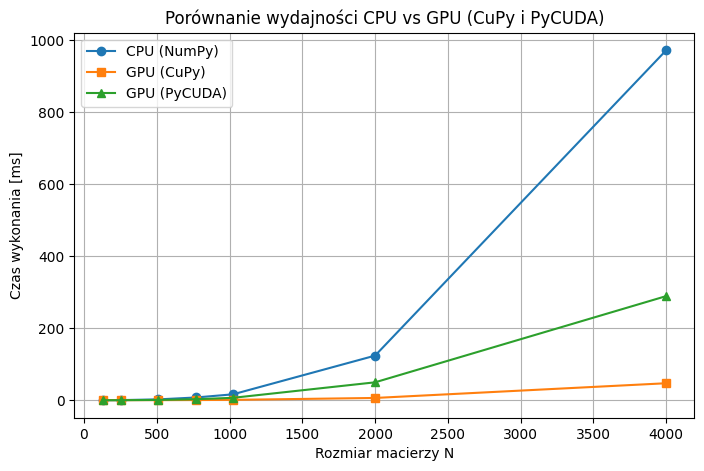

In [ ]:
import numpy as np
import cupy as cp
import time
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt

# Kernel z zadania 2
kernel_code = """
__global__ void matrixMul ( float *A, float *B, float *C, int N) {
    int row = blockIdx .y * blockDim .y + threadIdx .y;
    int col = blockIdx .x * blockDim .x + threadIdx .x;
    float sum = 0.0;
    if(row < N && col < N) {
        for (int k = 0; k < N; k++) {
            sum += A[ row * N + k] * B[ k * N + col ];
        }
        C[ row * N + col ] = sum;
    }
}
"""

mod = SourceModule(kernel_code)
matrixMul = mod.get_function("matrixMul")

# --- Funkcje pomocnicze ---

def measure_cpu(N):
    A = np.random.rand(N, N).astype(np.float32)
    B = np.random.rand(N, N).astype(np.float32)
    start = time.time()
    C = np.matmul(A, B)
    end = time.time()
    return (end - start) * 1000  # ms

def measure_cupy(N):
    A = cp.random.rand(N, N, dtype=cp.float32)
    B = cp.random.rand(N, N, dtype=cp.float32)
    start = time.time()
    C = cp.matmul(A, B)
    cp.cuda.Stream.null.synchronize()
    end = time.time()
    return (end - start) * 1000  # ms

def measure_pycuda(N):
    # Przygotowanie danych
    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)
    C_cpu = np.empty((N, N), np.float32)

    # Alokacja GPU
    A_gpu = cuda.mem_alloc(A_cpu.nbytes)
    B_gpu = cuda.mem_alloc(B_cpu.nbytes)
    C_gpu = cuda.mem_alloc(C_cpu.nbytes)

    cuda.memcpy_htod(A_gpu, A_cpu)
    cuda.memcpy_htod(B_gpu, B_cpu)

    block_size = (32, 32, 1)
    grid_size = (int(N / 32), int(N / 32), 1)

    start_evt = cuda.Event()
    end_evt = cuda.Event()
    start_evt.record()
    matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)
    end_evt.record()
    end_evt.synchronize()
    kernel_ms = start_evt.time_till(end_evt)

    del A_gpu, B_gpu, C_gpu
    return kernel_ms

# --- Główna pętla testów ---
Ns = [128, 256, 512, 768, 1024, 2000, 4000]
cpu_times = []
cupy_times = []
pycuda_times = []

for N in Ns:
    print(f"Test dla N = {N}")
    cpu_t = measure_cpu(N)
    gpu_cupy_t = measure_cupy(N)
    gpu_pycuda_t = measure_pycuda(N)
    cpu_times.append(cpu_t)
    cupy_times.append(gpu_cupy_t)
    pycuda_times.append(gpu_pycuda_t)
    print(f"  CPU: {cpu_t:.2f} ms, CuPy: {gpu_cupy_t:.2f} ms, PyCUDA: {gpu_pycuda_t:.2f} ms")

# --- Wykres ---
plt.figure(figsize=(8,5))
plt.plot(Ns, cpu_times, 'o-', label='CPU (NumPy)')
plt.plot(Ns, cupy_times, 's-', label='GPU (CuPy)')
plt.plot(Ns, pycuda_times, '^-', label='GPU (PyCUDA)')
plt.xlabel("Rozmiar macierzy N")
plt.ylabel("Czas wykonania [ms]")
plt.title("Porównanie wydajności CPU vs GPU (CuPy i PyCUDA)")
plt.legend()
plt.grid(True)
plt.show()